# Mage Wavelengths
    v1.0 -- X was fussing about
    v1.1 -- Generate the line list

In [1]:
%matplotlib notebook

In [2]:
# imports
from importlib import reload
import os
import numpy as np
from matplotlib import pyplot as plt
from pkg_resources import resource_filename

from scipy.io import readsav 

from astropy.io import fits
from astropy.table import Table

from pypeit.core.wavecal import templates, autoid, waveio, fitting
from pypeit.wavemodel import create_ThArlinelist

from linetools import utils as ltu

## Generate Synthetic ThAr Spectrum at R=4100

In [3]:
create_ThArlinelist(4100) # Generates ThAr_lines.dat locally; renamed ThAr_MagE_lines.dat and moved

[INFO]    :: wavemodel.py 460 optical_modelThAr() - Creating wavelength vector in velocity space.
[INFO]    :: wavemodel.py 468 optical_modelThAr() - Add in ThAr lines
[INFO]    :: wavemodel.py 244 thar_lines() - Reading in the ThAr spectrum
[INFO]    :: wavemodel.py 572 conv2res() - The binning of the wavelength array at 6012.997927538744 is: 0.03509988663063268
[INFO]    :: wavemodel.py 576 conv2res() - Covolving with a Gaussian kernel with sigma = 17.74232671358046 pixels
[WARNING] :: wavemodel.py 491 optical_modelThAr() - Model of the ThAr spectrum outside the template coverage.
[WARNING] :: wavemodel.py 494 optical_modelThAr() - Model of the ThAr spectrum outside the template coverage.
[WARNING] :: wavemodel.py 840 create_ThArlinelist() - No min FWHM for the line detection set. Derived from the resolution at the center of the spectrum
[WARNING] :: wavemodel.py 856 create_ThArlinelist() - No file_root_name as been set. The file will called ThAr_lines.dat
[INFO]    :: wavemodel.py 6

## Load up a few files

In [3]:
mase_path = os.path.join(os.getenv('XIDL_DIR'), 'Magellan', 'MAGE', 'mase', 'Calib')

### FITS

In [4]:
fits_file = os.path.join(mase_path, 'mage_archive_orders.fits')

In [6]:
hdu = fits.open(fits_file)
hdu.info()

Filename: /u/xavier/local/idl/xidl/Magellan/MAGE/mase/Calib/mage_archive_orders.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   (1024, 2048)   int16   
  1                1 BinTableHDU     31   2R x 5C   [8A, E, E, 75D, 2J]   


In [8]:
tbl = Table.read(fits_file)

In [9]:
tbl

FUNC,XMIN,XMAX,"COEFF [15,5]",DIMS [2]
bytes8,float32,float32,float64,int32
legendre,0.0,2047.0,-29.488265991210938 .. 0.056760191917419434,1024 .. 2048
legendre,0.0,2047.0,16.73930549621582 .. 0.06081448867917061,1024 .. 2048


### Save file

In [16]:
# This is the file called by mage_make_wvguess.pro
sav_file = os.path.join(mase_path, 'MagE_wvguess_jfh.idl')

In [17]:
mase_dict = readsav(sav_file)

In [18]:
mase_dict.keys()

dict_keys(['all_arcfit', 'guess_ordr', 'rejstr', 'sv_aspec', 'sv_lines'])

In [42]:
mase_dict['sv_aspec'].shape

(50, 2048)

In [45]:
mase_dict['sv_aspec'][0]

array([ 0.      ,  0.      ,  0.      , ...,  9.345445, 15.956247,
       16.58851 ], dtype=float32)

In [22]:
mase_sol = Table(mase_dict['all_arcfit'])
mase_sol[0:15]

FUNC,NORD,NRM,LSIG,HSIG,NITER,MINPT,MAXREJ,FLG_REJ,RMS,FFIT
object,int32,object,float32,float32,int32,int32,int32,int16,float64,object
CHEBY,4,[1438.34936523 1156.48046875],2.0,2.0,3,2,10,1,0.08395581692457199,[ 3.17522658e+03 1.30876111e+02 -1.63917588e+00 -2.28740563e-01]
CHEBY,4,[1264.26269531 1347.25488281],2.0,2.0,3,1,10,1,0.029286876320838928,[ 3.30072211e+03 1.62655519e+02 -2.09591494e+00 -2.50019866e-01]
CHEBY,4,[1262.87695312 1397.08422852],2.0,2.0,3,5,10,1,0.02182971127331257,[ 3.48423411e+03 1.77976047e+02 -2.32882913e+00 -2.89890825e-01]
CHEBY,5,[1230.67089844 1494.09765625],2.0,2.0,3,5,10,1,0.01800452172756195,[ 3.68080503e+03 2.01823819e+02 -2.66847564e+00 -3.76064860e-01 5.99505038e-02]
CHEBY,5,[1069.72802734 1884.94763184],2.0,2.0,3,5,10,1,0.017211703583598137,[ 3.86377879e+03 2.72407149e+02 -3.75086778e+00 -8.11355398e-01 1.85497801e-02]
CHEBY,6,[1032.24987793 1968.95336914],2.0,2.0,3,5,10,1,0.018749188631772995,[ 4.11007866e+03 3.03810572e+02 -4.13299244e+00 -9.49344614e-01 2.05792848e-02 3.73163644e-02]
CHEBY,5,[1119.57739258 1812.52099609],2.0,2.0,3,5,10,1,0.020683664828538895,[ 4.43342265e+03 2.98381705e+02 -4.18316990e+00 -8.15175520e-01 4.10919135e-02]
CHEBY,6,[1086.2557373 1877.31591797],2.0,2.0,3,5,10,1,0.030145803466439247,[ 4.76285002e+03 3.33158942e+02 -4.62836845e+00 -9.29628940e-01 3.98870604e-02 3.21320970e-02]
CHEBY,6,[1047.34692383 1954.54882812],2.0,2.0,3,2,10,1,0.033905938267707825,[ 5.14494175e+03 3.76122825e+02 -5.13063093e+00 -1.15591072e+00 2.96200137e-02 2.64080046e-02]


#### Test one

In [28]:
order = 0
wv_air = templates.cheby_val(mase_sol['FFIT'][order], np.arange(2048), mase_sol['NRM'][order], mase_sol['NORD'][order])

In [29]:
wv_air

array([2843.40730216, 2843.63366852, 2843.86005608, ..., 3310.22710183,
       3310.43748426, 3310.64782984])

In [31]:
order = 14
wv_air = templates.cheby_val(mase_sol['FFIT'][order], np.arange(2048), mase_sol['NRM'][order], mase_sol['NORD'][order])

In [32]:
wv_air

array([ 9481.8261232 ,  9482.60903289,  9483.39197296, ...,
       11045.78014217, 11046.48662502, 11047.19302061])

## Build the archive -- in templates.py

### Check how we have X-Shooter
    Ugly JSON approach.  Dumb

In [34]:
xshoot_file = os.path.join(resource_filename('pypeit', 'data'), 'arc_lines', 'reid_arxiv', 'vlt_xshooter_vis1x1.json')


In [37]:
xdict = ltu.loadjson(xshoot_file)

In [41]:
xdict.keys()

dict_keys(['0', '1', '10', '11', '12', '13', '14', '2', '3', '4', '5', '6', '7', '8', '9', 'fit2d', 'par', 'steps'])

In [40]:
xdict['0'].keys()

dict_keys(['cen_disp', 'cen_wave', 'fitc', 'fmax', 'fmin', 'function', 'ions', 'mask', 'nrej', 'nspec', 'pixel_fit', 'rms', 'shift', 'spec', 'tcent', 'wave_fit', 'wave_soln', 'weights', 'xrej', 'yrej'])

### Will write a 2D array in 'wave' and 'flux'

In [46]:
new_mage_file = os.path.join(resource_filename('pypeit', 'data'), 'arc_lines', 'reid_arxiv', 'magellan_mage.fits')
mage_reid = Table.read(new_mage_file)

In [48]:
mage_reid['wave'].shape

(2048, 15)

----

## Read back in

In [4]:
new_mage_file = os.path.join(resource_filename('pypeit', 'data'), 'arc_lines', 'reid_arxiv', 'magellan_mage.fits')

In [5]:
mage_wave = Table.read(new_mage_file)

In [6]:
mage_wave['wave'].shape

(2048, 15)

### Fuss with one

In [7]:
mage_wave.keys()

['wave', 'flux']

In [8]:
wv5 = mage_wave['wave'][:,5]
fx5 = mage_wave['flux'][:,5]

<IPython.core.display.Javascript object>


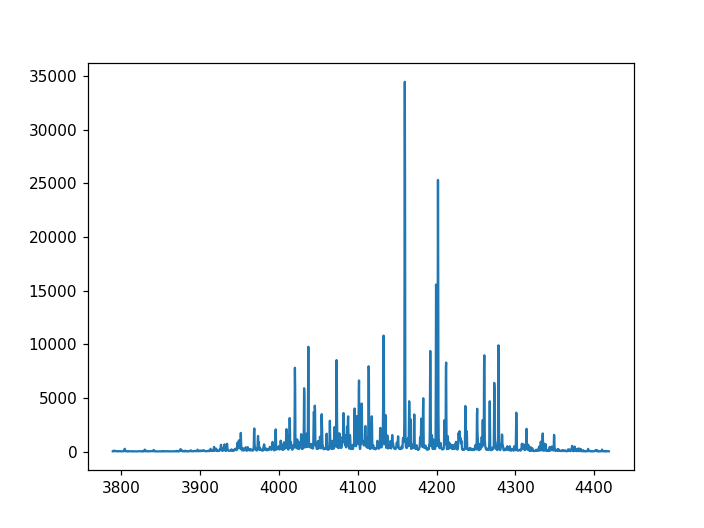

In [9]:
plt.clf()
ax = plt.gca()
ax.plot(wv5, fx5)
plt.show()

### Generate figures for fussing about

In [10]:
# Linelist
llist = waveio.load_line_lists(['ThAr_MagE'])

In [11]:
llist

wave,ion,NIST,Instr,amplitude,Source
float64,str4,int64,int64,float64,str12
3034.4515616388403,ThAr,1,32,3250.5330562821146,wavemodel.py
3094.2351186737014,ThAr,1,32,163.4091741852267,wavemodel.py
3140.0712478114897,ThAr,1,32,118.03246067794022,wavemodel.py
3170.5580546208257,ThAr,1,32,123.99931788498296,wavemodel.py
3181.14976954272,ThAr,1,32,160.1378083424093,wavemodel.py
3189.169932325525,ThAr,1,32,153.8608233826956,wavemodel.py
3196.585400263197,ThAr,1,32,104.46079002943156,wavemodel.py
3233.2380176392016,ThAr,1,32,150.16225080755922,wavemodel.py
3239.1470401332326,ThAr,1,32,130.3364122188992,wavemodel.py


#### Reidentify

In [12]:
reload(autoid)
detections, spec_cont_sub, patt_dict = autoid.reidentify(fx5, fx5, wv5, llist, 1)#, debug_xcorr=True,
                                                        #debug_reid=True, debug_peaks=True)

[INFO]    :: autoid.py 686 reidentify() - Cross-correlating with arxiv slit # 0


In [13]:
detections.shape

(140,)

In [14]:
patt_dict

{'acceptable': True,
 'nmatch': 99,
 'ibest': -1,
 'bwv': 4112.820570278643,
 'sign': 1,
 'mask': array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True, False,  True, False,  True,  True,  True,  True,  True,
        False,  True, False,  True, False,  True,  True,  True, False,
         True, False, False,  True,  True, False,  True,  True, False,
        False, False,  True, False,  True,  True,  True,  True,  True,
         True,  True,  True, False,  True, False, False,  True,  True,
        False,  True,  True,  True,  True,  True, False,  True,  True,
        False,  True,  True,  True,  True,  True, False, False,  True,
        False,  True,  True,  True, False,  True,  True, False,  True,
        False, False,  True,  True, False,  True, False,  True,  True,
         True, False, False,  True, False, False, False, False,  True,
        False,  True, False, False,  True,  True,  True,  True, False,
        False,  True,  True,  True,  True,  True,  

In [15]:
final_fit = fitting.fit_slit(fx5, patt_dict, detections, llist)

----

# TMP

In [20]:
np.arange(6,20)

array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])